In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [2]:
# load the dataset
data = open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/corpus').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# create a dataframe using texts and lables
trainDF = pandas.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels

In [3]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [4]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [5]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [35]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:

from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], #dtype='float32')

# create a tokenizer 
token = Tokenizer()
 token.fit_on_texts(texts)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

SyntaxError: ignored

In [17]:
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [18]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [19]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [20]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [21]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [22]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.8312
NB, WordLevel TF-IDF:  0.8424
NB, N-Gram Vectors:  0.83
NB, CharLevel Vectors:  0.808


In [23]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  0.8696
LR, WordLevel TF-IDF:  0.8724
LR, N-Gram Vectors:  0.8356
LR, CharLevel Vectors:  0.8352


In [24]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.8392


In [25]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  0.8424
RF, WordLevel TF-IDF:  0.8312


In [26]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  0.8036
Xgb, WordLevel TF-IDF:  0.7984
Xgb, CharLevel Vectors:  0.7976


In [27]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
print ("NN, Ngram Level TF IDF Vectors",  accuracy)

235/235 [==============================] - 1s 3ms/step - loss: 0.5234
NN, Ngram Level TF IDF Vectors 0.5012


In [33]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(texts)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)

NameError: ignored

In [37]:
# Add an Input Layer
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)

235/235 [==============================] - 22s 92ms/step - loss: 0.6930
RNN-LSTM, Word Embeddings 0.5012


In [38]:
# Add an Input Layer
def create_rnn_gru():
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)

235/235 [==============================] - 18s 78ms/step - loss: 0.6931
RNN-GRU, Word Embeddings 0.5012


In [39]:
# Add an Input Layer
def create_bidirectional_rnn():
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

235/235 [==============================] - 32s 136ms/step - loss: 0.6930
RNN-Bidirectional, Word Embeddings 0.5012


In [40]:
# Add an Input Layer
def create_rcnn():
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)

235/235 [==============================] - 7s 29ms/step - loss: 0.6931
CNN, Word Embeddings 0.5012


In [41]:
import sys

original_tweet = "I luv my &lt;3 iphone &amp; you’re awsm apple. DisplayIsAwesome, sooo happppppy 🙂 http://www.apple.com"

print('\n\nEscaping HTML Characters\n\n')

from html.parser import HTMLParser
html_parser = HTMLParser()
tweet = html_parser.unescape(original_tweet)
print(tweet)

html = HTMLParser()
tweet = html.unescape(original_tweet)
print(tweet)





Escaping HTML Characters


I luv my <3 iphone & you’re awsm apple. DisplayIsAwesome, sooo happppppy 🙂 http://www.apple.com
I luv my <3 iphone & you’re awsm apple. DisplayIsAwesome, sooo happppppy 🙂 http://www.apple.com


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  del sys.path[0]


1 accuracy: 1.0
2 accuracy: 1.0
3 accuracy: 1.0
4 accuracy: 1.0
5 accuracy: 1.0
6 accuracy: 1.0
7 accuracy: 1.0
8 accuracy: 1.0
9 accuracy: 1.0
10 accuracy: 1.0
1 accuracy: 1.0
2 accuracy: 1.0
3 accuracy: 1.0
4 accuracy: 1.0
5 accuracy: 1.0
6 accuracy: 1.0
7 accuracy: 1.0
8 accuracy: 1.0
9 accuracy: 1.0
10 accuracy: 1.0
1 accuracy: 1.0
2 accuracy: 1.0
3 accuracy: 1.0
4 accuracy: 1.0
5 accuracy: 1.0
6 accuracy: 1.0
7 accuracy: 1.0
8 accuracy: 1.0
9 accuracy: 1.0
10 accuracy: 1.0
1 accuracy: 1.0
2 accuracy: 1.0
3 accuracy: 1.0
4 accuracy: 1.0
5 accuracy: 1.0
6 accuracy: 1.0
7 accuracy: 1.0
8 accuracy: 1.0
9 accuracy: 1.0
10 accuracy: 1.0
       binary  count  tfidf  freq
count    10.0   10.0   10.0  10.0
mean      1.0    1.0    1.0   1.0
std       0.0    0.0    0.0   0.0
min       1.0    1.0    1.0   1.0
25%       1.0    1.0    1.0   1.0
50%       1.0    1.0    1.0   1.0
75%       1.0    1.0    1.0   1.0
max       1.0    1.0    1.0   1.0


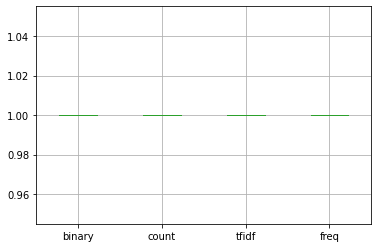

In [2]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
from matplotlib import pyplot
# nltk.download('stopwords')
import numpy as np
import tensorflow as tf 
tf.__version__
# !pip install tf-nightly
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)
# load all docs in a directory
def process_docs(directory, vocab, is_train):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
  # create the full path of the file to open
  path = directory + '/' + filename
  # load and clean the doc
  line = doc_to_line(path, vocab)
  # add to list
  lines.append(line)
  return lines
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
# load documents
  neg = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/neg', vocab, is_train)
  pos = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos', vocab, is_train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 10
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
    # define network
    model = define_model(n_words)
    # fit network
    Xtrain = np.array(Xtrain)
    ytrain = np.array(ytrain)
    Xtest = np.array(Xtest)
    ytest = np.array(ytest)
    model.fit(Xtrain, ytrain, epochs=10, verbose=0)
    # evaluate
    _, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))
  return scores
# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest
# load the vocabulary
vocab_filename = '/content/drive/My Drive/Colab Notebooks/vocab01.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
  # evaluate model on data for mode
  results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
  # summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()



In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.2MB 152kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import Word2Vec
sentences = ...
model = Word2Vec(sentences)

TypeError: ignored

In [ ]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
['this', 'is', 'the', 'second', 'sentence'],
['yet', 'another', 'sentence'],
['one', 'more', 'sentence'],
['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=14, size=100, alpha=0.025)
['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec', 'second', 'yet', 'another', 'one', 'more', 'and', 'final']
[-2.8318730e-03 -2.8268449e-04  8.1514200e-04 -3.7947411e-03
  4.3223463e-03  3.0344576e-03  9.9197810e-04 -4.3317596e-03
  2.3133599e-03  8.2665513e-04 -7.3584967e-04  4.4573690e-03
  2.8951676e-03 -4.4169626e-03  1.5201032e-03  3.3743656e-03
 -2.8880602e-03  3.8602909e-03  2.2268295e-03 -1.2968124e-03
  1.2393267e-03  1.9216972e-03  1.6629514e-03 -4.1449694e-03
 -1.6814864e-03 -3.8846380e-03 -2.3482742e-03  4.7685667e-03
 -9.1106165e-04  4.5405212e-03 -3.5743420e-03  4.9702786e-03
 -4.8561017e-03  1.8626781e-03 -2.0468486e-03  1.5601472e-03
 -2.6336845e-03 -8.8910671e-04 -2.7352267e-05  3.8741913e-03
 -2.7582403e-03  2.6389714e-03  1.1749073e-03  1.8468602e-03
  7.6382747e-04 -2.1125207e-04 -9.6447027e-04 -1.6190129e-03
  6.2694226e-04  2.1968111e-03 -4.2003766e-04  3.5172356e-03
 -4.1186693e-03  3.1198433e-03 -1.0765992e-0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


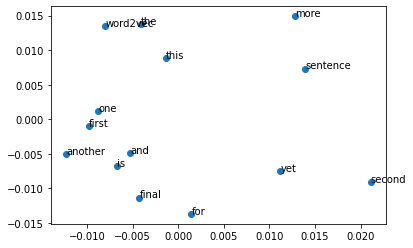

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
['this', 'is', 'the', 'second', 'sentence'],
['yet', 'another', 'sentence'],
['one', 'more', 'sentence'],
['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
'Good work',
'Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()
# fit the model
padded_docs = np.array(padded_docs)
labels = np.array(labels)
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[42, 44], [11, 43], [49, 30], [12, 43], [4], [25], [43, 30], [16, 11], [43, 43], [26, 29, 44, 10]]
[[42 44  0  0]
 [11 43  0  0]
 [49 30  0  0]
 [12 43  0  0]
 [ 4  0  0  0]
 [25  0  0  0]
 [43 30  0  0]
 [16 11  0  0]
 [43 43  0  0]
 [26 29 44 10]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
Accuracy: 89.999998


In [ ]:
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = ['Well done!',
'Good work',
'Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]
labels = np.array(labels)
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_docs = np.array(padded_docs)
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))


[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Loaded 400000 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 4, 100)            1500      
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 401       
Total params: 1,901
Trainable params: 401
Non-trainable params: 1,500
_________________________________________________________________
Accuracy: 89.999998


In [ ]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc, vocab):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # filter out tokens not in vocab
  tokens = [w for w in tokens if w in vocab]
  tokens = ' '.join(tokens)
  return tokens
# load all docs in a directory
def process_docs(directory, vocab, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc, vocab)
    # add to list
    documents.append(tokens)
  return documents
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
  # load documents
  neg = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/neg', vocab, is_train)
  pos = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos', vocab, is_train)
  docs = neg + pos
  # prepare labels
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
  # integer encode
  encoded = tokenizer.texts_to_sequences(docs)
  # pad sequences
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, max_length, model):
  # clean review
  line = clean_doc(review, vocab)
  # encode and pad review
  padded = encode_docs(tokenizer, max_length, [line])
  # predict sentiment
  yhat = model.predict(padded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'
# load the vocabulary
vocab_filename = '/content/drive/My Drive/Colab Notebooks/txt_sentoken/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)
# load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/txt_sentoken/model.h5')
# evaluate model on training dataset
_, acc = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %.2f' % (acc*100))
# test positive text
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Vocabulary size: 14781
Maximum length: 1244


OSError: ignored

In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# load the vocabulary
vocab_filename = '/content/drive/My Drive/Colab Notebooks/txt_sentoken/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [ ]:
# turn a doc into clean tokens
def clean_doc(doc, vocab):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # filter out tokens not in vocab
  tokens = [w for w in tokens if w in vocab]
  tokens = ' '.join(tokens)
  return tokens

In [ ]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc, vocab)
    # add to list
    documents.append(tokens)
  return documents

In [ ]:
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
  # load documents
  neg = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/neg', vocab, is_train)
  pos = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos', vocab, is_train)
  docs = neg + pos
  # prepare labels
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs, labels

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Maximum length: 1244


In [ ]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
  # integer encode
  encoded = tokenizer.texts_to_sequences(docs)
  # pad sequences
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [ ]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 14781


In [ ]:
# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length=max_length))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model2.png', show_shapes=True)
  return model

In [ ]:
import tensorflow as tf 
tf.__version__

'2.4.0-dev20200830'

In [ ]:
import numpy as np
import pandas as pd
import random
import time as tm

In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 344.7MB 48kB/s 
     |████████████████████████████████| 9.0MB 44.2MB/s 
     |████████████████████████████████| 460kB 44.2MB/s 


In [18]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

In [8]:
# define the model
def define_model(vocab_size, max_length):
  from .models import model
  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length=max_length))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model1.png', show_shapes=True)
  return model
  # fit network
  model.fit(Xtrain, ytrain, epochs=10, verbose=2)
  # save the model
  model.save('/content/drive/My Drive/Colab Notebooks/txt_sentoken/model.h5')
  # fit network
  Xtrain = np.array(Xtrain)
  ytrain = np.array(ytrain)
  model.fit(Xtrain, ytrain, epochs=10, verbose=2)

In [9]:
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)

In [10]:
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)

NameError: ignored

In [11]:
# load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/txt_sentoken/model.h5')
# evaluate model on training dataset
_, acc = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

OSError: ignored

In [12]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, max_length, model):
  # clean review
  line = clean_doc(review, vocab)
  # encode and pad review
  padded = encode_docs(tokenizer, max_length, [line])
  # predict sentiment
  yhat = model.predict(padded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
import string
import re
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens
# load the document
filename = '/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

In [ ]:
# load all docs in a directory
def process_docs(directory, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc)
    # add to list
    documents.append(tokens)
  return documents

In [ ]:
# load and clean a dataset
def load_clean_dataset(is_train):
  # load documents
  neg = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/neg', is_train)
  pos = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos', is_train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

In [ ]:
# save a dataset to file
def save_dataset(dataset, filename):
  dump(dataset, open(filename, 'wb'))
  print('Saved: %s' % filename)

In [ ]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from pickle import dump
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  tokens = ' '.join(tokens)
  return tokens
# load all docs in a directory
def process_docs(directory, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc)
    # add to list
    documents.append(tokens)
  return documents
# load and clean a dataset
def load_clean_dataset(is_train):
  # load documents
  neg = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/neg', is_train)
  pos = process_docs('/content/drive/My Drive/Colab Notebooks/txt_sentoken/pos', is_train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels
# save a dataset to file
def save_dataset(dataset, filename):
  dump(dataset, open(filename, 'wb'))
  print('Saved: %s' % filename)
# load and clean all reviews
train_docs, ytrain = load_clean_dataset(True)
test_docs, ytest = load_clean_dataset(False)
# save training datasets
save_dataset([train_docs, ytrain], '/content/drive/My Drive/Colab Notebooks/txt_sentoken/train.pkl')
save_dataset([test_docs, ytest], '/content/drive/My Drive/Colab Notebooks/txt_sentoken/test.pkl')

Saved: /content/drive/My Drive/Colab Notebooks/txt_sentoken/train.pkl
Saved: /content/drive/My Drive/Colab Notebooks/txt_sentoken/test.pkl


In [ ]:
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
# calculate the maximum document length
def max_length(lines):
  return max([len(s.split()) for s in lines])
# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded
# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize
  model.summary()
  plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model.png')
  return model
# load training dataset
trainLines, trainLabels = load_dataset('/content/drive/My Drive/Colab Notebooks/txt_sentoken/train.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
trainX = np.array(trainX)
trainLabels = np.array(trainLabels)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], trainLabels, epochs=7, batch_size=16)
# save the model
model.save('/content/model.h5')



Max document length: 1380
Vocabulary size: 44277
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1380, 100)    4427700     input_4[0][0]                    
___________________________________________

In [ ]:
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))
  # fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
# calculate the maximum document length
def max_length(lines):
  return max([len(s.split()) for s in lines])
# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded
# load datasets
trainLines, trainLabels = load_dataset('/content/drive/My Drive/Colab Notebooks/txt_sentoken/train.pkl')
testLines, testLabels = load_dataset('/content/drive/My Drive/Colab Notebooks/txt_sentoken/test.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
trainX = np.array(trainX)
trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)
testX = encode_text(tokenizer, testLines, length)
testX = np.array(testX)
# load the model
model = load_model('/content/model.h5')
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX], trainLabels, verbose=0)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX], testLabels, verbose=0)
print('Test Accuracy: %.2f' % (acc*100))

Max document length: 1380
Vocabulary size: 44277
Train Accuracy: 100.00
Test Accuracy: 86.50


In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

In [ ]:
# load text
raw_text = load_doc('/content/drive/My Drive/Colab Notebooks/rhyme.txt')
print(raw_text)

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.

When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.

The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.

The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.


In [ ]:
# clean
tokens = raw_text.split()
raw_text = ' '.join(tokens)

In [ ]:
# organize into sequences of characters
length = 10
sequences = list()
for i in range(length, len(raw_text)):
  # select sequence of tokens
  seq = raw_text[i-length:i+1]
  # store
  sequences.append(seq)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 399


In [ ]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

In [ ]:
# save sequences to file
out_filename = '/content/drive/My Drive/Colab Notebooks/char_sequences.txt'
save_doc(sequences, out_filename)

In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# load
in_filename = '/content/drive/My Drive/Colab Notebooks/char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')

In [ ]:
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))

In [ ]:
sequences = list()
for line in lines:
  # integer encode line
  encoded_seq = [mapping[char] for char in line]
  # store
  sequences.append(encoded_seq)

# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 38


In [ ]:
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

In [ ]:
from keras.utils import to_categorical
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
X = array(sequences)
y = to_categorical(y, num_classes=vocab_size)

In [ ]:
# define the model
def define_model(X):
  model = Sequential()
  model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model5.png', show_shapes=True)
  return model

In [ ]:
# save the model to file
model.save('/content/drive/My Drive/Colab Notebooks/txt_sentoken/model5.png')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/txt_sentoken/model5.png/assets


In [ ]:
from pickle import dump
# save the mapping
dump(mapping, open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/mapping.pkl', 'wb'))

In [ ]:
from numpy import array
from pickle import dump
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# define the model
def define_model(X):
  model = Sequential()
  model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model4.png', show_shapes=True)
  return model
# load
in_filename = '/content/drive/My Drive/Colab Notebooks/char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')
# integer encode sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))
sequences = list()
for line in lines:
  # integer encode line
  encoded_seq = [mapping[char] for char in line]
  # store
  sequences.append(encoded_seq)
# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
X = array(sequences)
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(X)
# fit model
X = np.array(X)
y = np.array(y)
model.fit(X, y, epochs=100, verbose=2)
# save the model to file
model.save('/content/drive/My Drive/Colab Notebooks/model1.h5')
# save the mapping
dump(mapping, open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/mapping.pkl', 'wb'))

Vocabulary Size: 38
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 75)                34200     
_________________________________________________________________
dense_6 (Dense)              (None, 38)                2888      
Total params: 37,088
Trainable params: 37,088
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 - 2s - loss: 3.6034 - accuracy: 0.1253
Epoch 2/100
13/13 - 0s - loss: 3.4774 - accuracy: 0.1905
Epoch 3/100
13/13 - 0s - loss: 3.1749 - accuracy: 0.1905
Epoch 4/100
13/13 - 0s - loss: 3.0448 - accuracy: 0.1905
Epoch 5/100
13/13 - 0s - loss: 3.0043 - accuracy: 0.1905
Epoch 6/100
13/13 - 0s - loss: 2.9834 - accuracy: 0.1905
Epoch 7/100
13/13 - 0s - loss: 2.9603 - accuracy: 0.1905
Epoch 8/100
13/13 - 0s - loss: 2.9453 - accuracy: 0.1905
Epoch 9/100
13/13 - 0s - loss: 2.926

In [ ]:
# load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/model1.h5')

In [ ]:
# load the mapping
mapping = load(open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/mapping.pkl', 'rb'))

In [16]:
from pickle import load
from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
  in_text = seed_text
  # generate a fixed number of characters
  for _ in range(n_chars):
    # encode the characters as integers
    encoded = [mapping[char] for char in in_text]
    # truncate sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
    # one hot encode
    encoded = to_categorical(encoded, num_classes=len(mapping))
    encoded = np.array(encoded)
    encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])
    # predict character
    yhat = np.argmax(model.predict(encoded), axis=-1)
    # reverse map integer to character
    out_char = ''
    for char, index in mapping.items():
      if index == yhat:
        out_char = char
        break
    # append to input
    in_text += out_char
  return in_text

In [17]:
# load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/model1.h5')
# load the mapping
mapping = load(open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/mapping.pkl', 'rb'))
# test start of rhyme
print(generate_seq(model, mapping, 1, 'Sing a son', 20))
# test mid-line
print(generate_seq(model, mapping, 1, 'king was i', 20))
# test not in original
print(generate_seq(model, mapping, 1, 'hello worl', 20))

Sing a songourd pe pe pe pe pe
king was ingourd pe pe pe pe p
hello worlourd pe pe pe pe pe 


In [ ]:
from pickle import load
from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
# generate a sequence of characters with a language model
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
  in_text = seed_text
  # generate a fixed number of characters
  for _ in range(n_chars):
    # encode the characters as integers
    encoded = [mapping[char] for char in in_text]
    # truncate sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
    # one hot encode
    encoded = to_categorical(encoded, num_classes=len(mapping))
    encoded = np.array(encoded)
    encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])
    # predict character
    yhat = np.argmax(model.predict(encoded), axis=-1)
    # reverse map integer to character
    out_char = ''
    for char, index in mapping.items():
      if index == yhat:
        out_char = char
        break
    # append to input
    in_text += out_char
  return in_text
# load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/model1.h5')
# load the mapping
mapping = load(open('/content/drive/My Drive/Colab Notebooks/txt_sentoken/mapping.pkl', 'rb'))
# test start of rhyme
print(generate_seq(model, mapping, 1, 'Sing a son', 100))
# test mid-line
print(generate_seq(model, mapping, 1, 'king was i', 100))
# test not in original
print(generate_seq(model, mapping, 1, 'hello worl', 100))


Sing a songourd pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe p
king was ingourd pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe 
hello worlourd pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe pe


In [ ]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
  in_text, result = seed_text, seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    encoded = array(encoded)
    # predict a word in the vocabulary
    #yhat = model.predict_classes(encoded, verbose=0)
    yhat = np.argmax(model.predict(encoded), axis=-1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word
        break
    # append to input
    in_text, result = out_word, result + ' ' + out_word
  return result
# define the model
def define_model(vocab_size):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length=1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation='softmax'))
#  compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model6.png', show_shapes=True)
  return model
# source text
data = """ Jack and Jill went up the hill\n
To fetch a pail of water\n
Jack fell down and broke his crown\n
And Jill came tumbling after\n """
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
  sequence = encoded[i-1:i+1]
  sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# split into X and y elements
sequences = array(sequences)
X, y = sequences[:,0],sequences[:,1]
# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size)
# fit network
X = np.array(X)
y = np.array(y)
model.fit(X, y, epochs=500, verbose=2)
# evaluate
print(generate_seq(model, tokenizer, 'Jack', 6))

Vocabulary Size: 22
Total Sequences: 24
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1, 10)             220       
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_12 (Dense)             (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 2s - loss: 3.0906 - accuracy: 0.0000e+00
Epoch 2/500
1/1 - 0s - loss: 3.0898 - accuracy: 0.0417
Epoch 3/500
1/1 - 0s - loss: 3.0890 - accuracy: 0.0833
Epoch 4/500
1/1 - 0s - loss: 3.0882 - accuracy: 0.1250
Epoch 5/500
1/1 - 0s - loss: 3.0874 - accuracy: 0.1250
Epoch 6/500
1/1 - 0s - loss: 3.0866 - accuracy: 0.1250
Epoch 

In [ ]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
  in_text = seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    # pre-pad sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    # predict probabilities for each word
    # yhat = model.predict_classes(encoded, verbose=0)
    yhat = np.argmax(model.predict(encoded), axis=-1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word
        break
    # append to input
    in_text += ' ' + out_word
  return in_text
# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length=max_length-1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model7.png', show_shapes=True)
  return model
# source text
data = """ Jack and Jill went up the hill\n
    To fetch a pail of water\n
    Jack fell down and broke his crown\n
    And Jill came tumbling after\n """
# prepare the tokenizer on the source text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# create line-based sequences
sequences = list()
for line in data.split('\n'):
  encoded = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# pad input sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size, max_length)
# fit network
X = np.array(X)
y = np.array(y)
model.fit(X, y, epochs=500, verbose=2)
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack', 4))
print(generate_seq(model, tokenizer, max_length-1, 'Jill', 4))

Vocabulary Size: 22
Total Sequences: 21
Max Sequence Length: 7
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 6, 10)             220       
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_14 (Dense)             (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 2s - loss: 3.0901 - accuracy: 0.0476
Epoch 2/500
1/1 - 0s - loss: 3.0884 - accuracy: 0.0952
Epoch 3/500
1/1 - 0s - loss: 3.0868 - accuracy: 0.1429
Epoch 4/500
1/1 - 0s - loss: 3.0851 - accuracy: 0.1429
Epoch 5/500
1/1 - 0s - loss: 3.0834 - accuracy: 0.1429
Epoch 6/500
1/1 - 0s - loss: 3.0816 - acc

In [ ]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
  in_text = seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    # pre-pad sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    # predict probabilities for each word
    # yhat = model.predict_classes(encoded, verbose=0)
    yhat = np.argmax(model.predict(encoded), axis=-1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word
        break
    # append to input
    in_text += ' ' + out_word
  return in_text
# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length=max_length-1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model8.png', show_shapes=True)
  return model
# source text
data = """ Jack and Jill went up the hill\n
    To fetch a pail of water\n
    Jack fell down and broke his crown\n
    And Jill came tumbling after\n """
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]
# retrieve vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
  sequence = encoded[i-2:i+1]
  sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size, max_length)
# fit network
X = np.array(X)
y = np.array(y)
model.fit(X, y, epochs=1000, verbose=2)
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack and', 5))
print(generate_seq(model, tokenizer, max_length-1, 'And Jill', 3))
print(generate_seq(model, tokenizer, max_length-1, 'fell down', 5))
print(generate_seq(model, tokenizer, max_length-1, 'pail of', 5))

Vocabulary Size: 22
Total Sequences: 23
Max Sequence Length: 3
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 2, 10)             220       
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_16 (Dense)             (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 - 2s - loss: 3.0913 - accuracy: 0.0000e+00
Epoch 2/1000
1/1 - 0s - loss: 3.0904 - accuracy: 0.0000e+00
Epoch 3/1000
1/1 - 0s - loss: 3.0895 - accuracy: 0.0870
Epoch 4/1000
1/1 - 0s - loss: 3.0886 - accuracy: 0.0870
Epoch 5/1000
1/1 - 0s - loss: 3.0877 - accuracy: 0.0870
Epoch 6/1000
1/1 - 0s - loss

In [ ]:
import string
import re
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# turn a doc into clean tokens
def clean_doc(doc):
  # replace '--' with a space ' '
  doc = doc.replace('--', ' ')
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # make lower case
  tokens = [word.lower() for word in tokens]
  return tokens
# save tokens to file, one dialog per line
def save_doc(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
# load document
in_filename = '/content/drive/My Drive/Colab Notebooks/republic_clean.txt'
doc = load_doc(in_filename)
print(doc[:200])
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
  # select sequence of tokens
  seq = tokens[i-length:i]
  # convert into a line
  line = ' '.join(seq)
  # store
  sequences.append(line)
print('Total Sequences: %d' % len(sequences))
# save sequences to file
out_filename = '/content/drive/My Drive/Colab Notebooks/republic_sequences.txt'
save_doc(sequences, out_filename)

BOOK I. The Republic opens with a truly Greek scene--a festival in
honour of the goddess Bendis which is held in the Piraeus; to this is
added the promise of an equestrian torch-race in the evening. T
['book', 'i', 'the', 'republic', 'opens', 'with', 'a', 'truly', 'greek', 'scene', 'a', 'festival', 'in', 'honour', 'of', 'the', 'goddess', 'bendis', 'which', 'is', 'held', 'in', 'the', 'piraeus', 'to', 'this', 'is', 'added', 'the', 'promise', 'of', 'an', 'equestrian', 'torchrace', 'in', 'the', 'evening', 'the', 'whole', 'work', 'is', 'supposed', 'to', 'be', 'recited', 'by', 'socrates', 'on', 'the', 'day', 'after', 'the', 'festival', 'to', 'a', 'small', 'party', 'consisting', 'of', 'critias', 'timaeus', 'hermocrates', 'and', 'another', 'this', 'we', 'learn', 'from', 'the', 'first', 'words', 'of', 'the', 'timaeus', 'when', 'the', 'rhetorical', 'advantage', 'of', 'reciting', 'the', 'dialogue', 'has', 'been', 'gained', 'the', 'attention', 'is', 'not', 'distracted', 'by', 'any', 'reference', '

In [ ]:
from numpy import array
import numpy as np
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
# define the model
def define_model(vocab_size, seq_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=seq_length))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/txt_sentoken/model9.png', show_shapes=True)
  return model
# load
in_filename = '/content/drive/My Drive/Colab Notebooks/republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
# define model
model = define_model(vocab_size, seq_length)
# fit model
X = np.array(X)
y = np.array(y)
model.fit(X, y, batch_size=128, epochs=100)
# save the model to file
model.save('/content/drive/My Drive/Colab Notebooks/model2.h5')
# save the tokenizer
dump(tokenizer, open('/content/drive/My Drive/Colab Notebooks/tokenizer.pkl', 'wb'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            513550    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 10271)             1037371   
Total params: 1,701,821
Trainable params: 1,701,821
Non-trainable params: 0
_________________________________________________________________
